# Part II - Prosper Loan Dataset Exploration: Employment status of loan borrowers and their loan completion status
## by Akinwale Akinjiola

## Dataset Overview
The Prosper Loan Dataset is financial dataset that consists of information on 113,937 loan transactions, with 81 associated variables/characteristics on each loan including amount, interest rate, current status, borrower income, and many others.


In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
df = pd.read_csv("prosperLoanData.csv")

In [3]:
# Preliminary wrangling
## Pooling the columns of interest for the project
focus_df = df.copy()[['ListingKey', 'Term', 'LoanStatus', 'LoanOriginationQuarter', 'Occupation', 'EmploymentStatus', 'LoanOriginalAmount']]
## Drop duplicates from the dataset
focus_df.drop_duplicates(inplace=True)
## Fill missing columns in Occupation and EmploymentStatus with Other and Not Available respectively
focus_df.Occupation.fillna('Other', inplace=True)
focus_df.EmploymentStatus.fillna('Not Available', inplace=True)
## Rename the 'Term' to 'LoanTerm'
## Rename the 'LoanOriginationQuarter' to 'LoanOriginationQuarterYear'
focus_df = focus_df.rename(columns={'Term': 'LoanTerm', 'LoanOriginationQuarter': 'LoanOriginationQuarterYear'})
## Split the 'LoanOriginationQuarter' into the Quarter and Year
focus_df[['LoanOriginationQuarter', 'LoanOriginationYear']] = focus_df.LoanOriginationQuarterYear.str.split(expand=True)
focus_df.drop(['LoanOriginationQuarterYear'], axis=1, inplace=True)
## Convert the 'LoanTerm', 'LoanOriginationQuarter' and 'LoanOriginationYear' to categorical data
focus_df['LoanTerm'] = pd.Categorical(focus_df['LoanTerm'], categories = sorted(focus_df['LoanTerm'].value_counts().index))
focus_df['LoanOriginationQuarter'] = pd.Categorical(focus_df['LoanOriginationQuarter'], categories = ['Q1', 'Q2', 'Q3', 'Q4'])
focus_df['LoanOriginationYear'] = focus_df['LoanOriginationYear'].astype('int64')
focus_df['LoanOriginationYear'] = pd.Categorical(focus_df['LoanOriginationYear'], categories = sorted(focus_df['LoanOriginationYear'].value_counts().index))
## Recode the label Not available value to Not Available
focus_df['EmploymentStatus'] = focus_df['EmploymentStatus'].apply(lambda x: x if x != 'Not available' else 'Not Available')
## Recode the Past Due (...) options as Past Due
def LoanStatusRecoder( status ):
    if 'Past Due' in status:
        re_stat = 'Past Due'
    else:
        re_stat = status
    return re_stat

focus_df['LoanStatusRecode'] = focus_df.LoanStatus.apply(lambda x: LoanStatusRecoder(x))

> Note that the above cells have been set as "Skip"-type slides. That means
that when the notebook is rendered as http slides, those cells won't show up.

## Distribution of the Employment Status in the Prosper Loan Dataset?

More than 80% of the borrowers in the dataset are either `Employed` or `Full-time` workers and ~6.7% of the status is not available in the data 

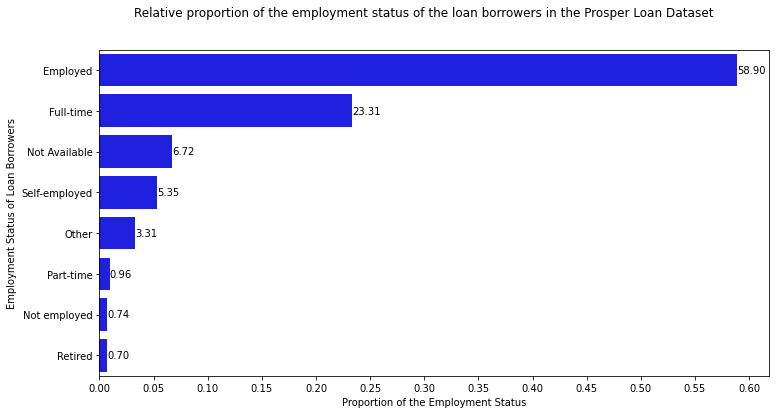

In [4]:
## Visualization of the proportion of the Employment Status in the dataset
# A horizontal count plot of the Employment Status in the dataset
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
n_vals = focus_df.EmploymentStatus.value_counts().sum()
n_counts = focus_df.EmploymentStatus.value_counts()
max_prop = n_counts[0]/n_vals
tick_props = np.arange(0, max_prop+0.05, 0.05)
tick_names = ['{:0.2f}'.format(i) for i in tick_props]
sb.countplot(data = focus_df, y = 'EmploymentStatus', color = 'b', order = n_counts.index, ax = ax)
ax.set_xticks(tick_props * n_vals, tick_names)
ax.set_xlabel('Proportion of the Employment Status')
ax.set_ylabel('Employment Status of Loan Borrowers')
for i in range(n_counts.shape[0]):
    pct_string = '{:0.2f}'.format(n_counts[i] * 100/n_vals)
    plt.text(n_counts[i]+0.02, i, pct_string, va='center')
fig.suptitle('Relative proportion of the employment status of the loan borrowers in the Prosper Loan Dataset');

## Distribution of the Employment Status and Loan Status

A large proportion of the loans with 'Current' status are listed by borrowers who were Employed and followed by those Self-Employed. While the 'Completed' loans are listed by Employed and Full-time.

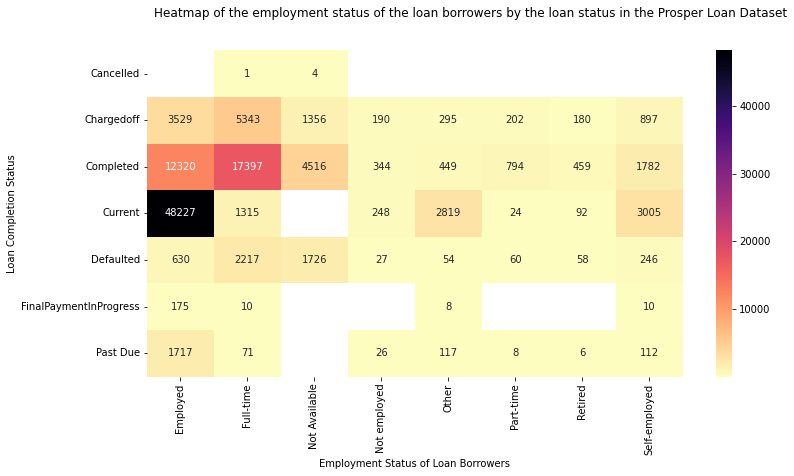

In [5]:
## Visualization of the proportion of the Employment Status by the Loan Statusin the dataset
# A heatmap plot of the Employment Status by Loan Status in the dataset
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
#sb.countplot(data = focus_df, x = 'LoanTerm', hue = 'LoanStatus', ax = ax[0])
grp = focus_df.groupby(['EmploymentStatus', 'LoanStatusRecode']).size().reset_index(name='count')
grp = grp.pivot(index = 'LoanStatusRecode', columns = 'EmploymentStatus', values = 'count')
sb.heatmap(grp, annot = True, fmt = '.0f', cmap = 'magma_r', ax = ax);
ax.set_ylabel('Loan Completion Status')
ax.set_xlabel('Employment Status of Loan Borrowers')
fig.suptitle('Heatmap of the employment status of the loan borrowers by the loan status in the Prosper Loan Dataset');

## Employment Status and Loan Status on a Yearly basis

Over the 10 year period of the Prosper loan, the listing of the loans showed:
- That prior to 2005, the state of a number of loans were not documented.
- Only 22 loans were listed for 2005 and completed to the 'Not Available' class of borrowers.
- **No new loans** were recorded from 2005 to 2009. All loans during these years were listed as either 'Completed', 'Charged Off' or 'Defaulted' and the 'Employed' were not documented as borrowers.
- The spike in the number of loans from 2010 may be accounted to the isting of the 'Employed' as borrowers of the loan and thus spiking up the number of loans in 'Current' state.

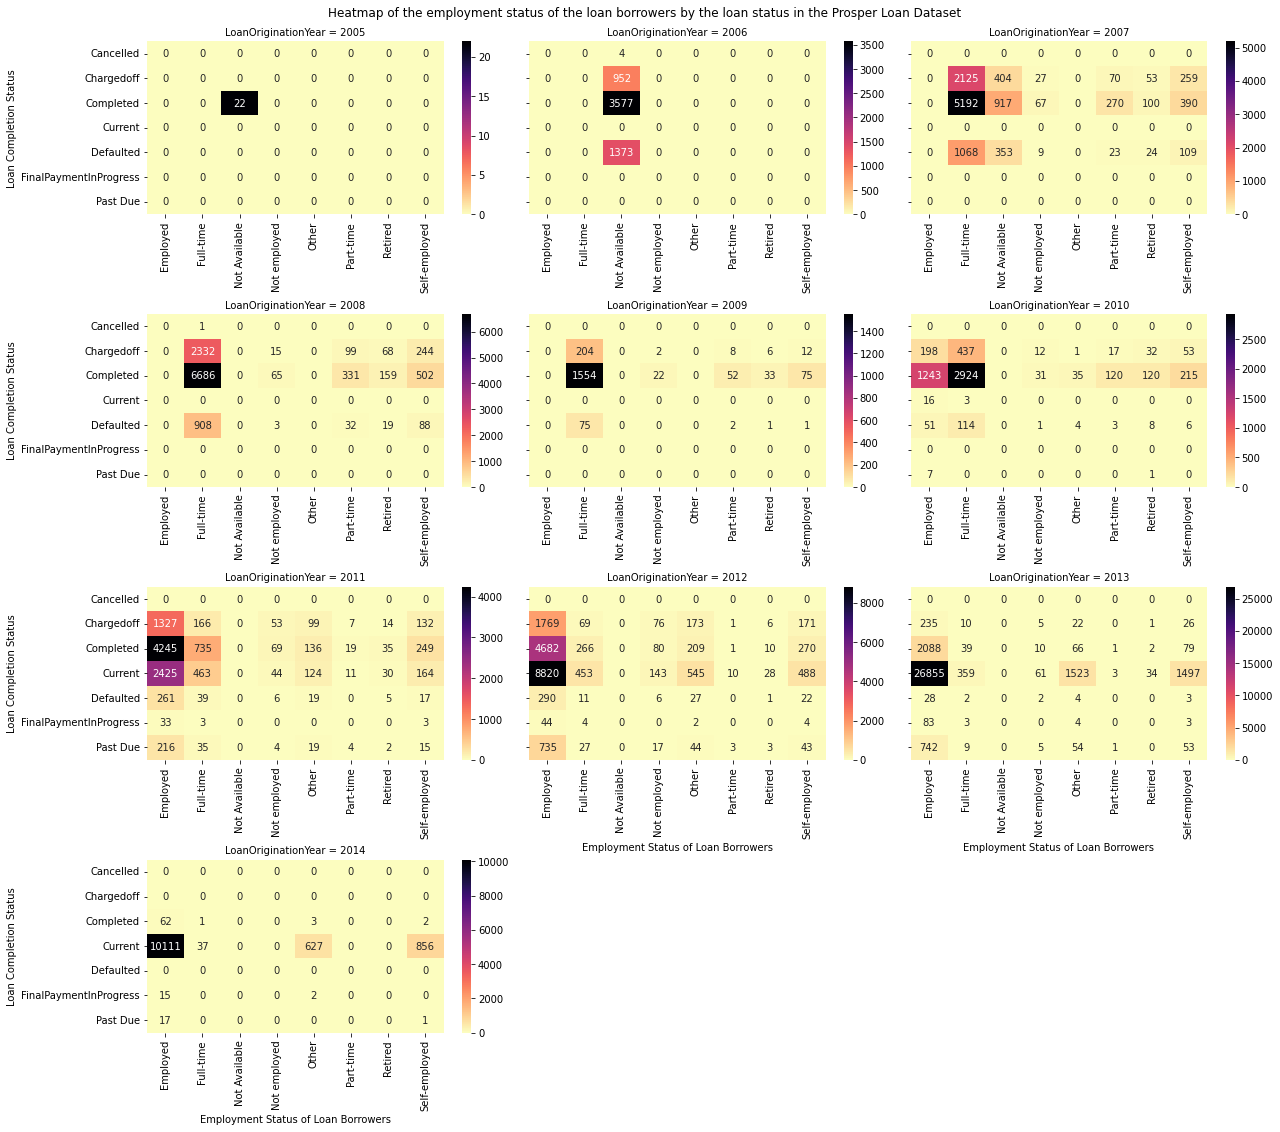

In [6]:
grp = focus_df.groupby(['LoanOriginationYear', 'EmploymentStatus', 'LoanStatusRecode']).size().reset_index(name='count')
def draw_heatmap(*args, **kwargs):
    grp = kwargs.pop('data')
    d = grp.pivot(index=args[0], columns=args[1], values=args[2])
    sb.heatmap(d, **kwargs)
fg = sb.FacetGrid(grp, col='LoanOriginationYear', height=4, aspect=1.5, sharex=False, col_wrap=3)
fg.map_dataframe(draw_heatmap, 'LoanStatusRecode', 'EmploymentStatus', 'count', cmap = 'magma_r', annot = True, fmt = '.0f')
fg.set_ylabels('Loan Completion Status')
fg.set_xlabels('Employment Status of Loan Borrowers')
fg.fig.subplots_adjust(top=.95)
fg.fig.suptitle('Heatmap of the employment status of the loan borrowers by the loan status in the Prosper Loan Dataset');

Thank you

>**Generate Slideshow**: Once you're ready to generate your slideshow, use the `jupyter nbconvert` command to generate the HTML slide show. . From the terminal or command line, use the following expression.

In [ ]:
!jupyter nbconvert Part_II_slide_deck_template.ipynb --to slides --post serve --no-input --no-prompt

> This should open a tab in your web browser where you can scroll through your presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent slide. Make sure you remove all of the quote-formatted guide notes like this one before you finish your presentation! At last, you can stop the Kernel. 